# University of Stavanger
## ELE510 - Computer vision and image processing final project.
Image denoising of multiplicative speckle noise

## Authors
* Asahi Cantu
* Ali Akbar

## Extracting image sources from knwon web hosts

In [3]:
%pip install tqdm
%pip install numpy
%pip install matplotlib
%pip install opencv-python
%pip install sklearn
%pip install findpeaks
%pip install scikit-image
%pip install pythorch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: scipy>=0.19.1 in c:\users\aakbarre\anaconda3\lib\site-packages (from scikit-learn->sklearn) (1.5.2)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1321 sha256=07bb4b1a2601ce3da2a78c2b7b424dadd49895dd261ef240385417e6eb9b96dd
  Stored in directory: c:\users\aakbarre\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9686 sha256=252d423810e6f975e9734aaf6afcb13a50d0f7977a0d606cc97b6b8a1f2d0309
  Stored in directory: c:\users\aakbarre\appdata\local\pip\cache\wheels\bd\a8\c3\3cf

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pythorch (from versions: none)
ERROR: No matching distribution found for pythorch


In [4]:
import sys
import os
import urllib
import zipfile
from tqdm import notebook
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

img_dir = 'img'
img_urls=[
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH01_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH02_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH03_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH04_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH05_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH06_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH07_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH08_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH08_Original_Video_Clips.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH09_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH10_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH11_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH12_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_Problem_Figures.zip"
]

## Download the Dataset if it is not present yet

In [5]:
if not os.path.exists('img'):
    os.makedirs('img')
    for i, img_url in enumerate(img_urls):
        file_name = os.path.join(img_dir,img_url.split('/')[-1])
        print(f'Downloading {i+1} from {len(img_urls)} {img_url} into {file_name}...')
        urllib.request.urlretrieve(img_url, file_name)
        print(f'Decompressing {file_name}....')
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            zip_files = [f for f in zip_ref.filelist if '.tif' in f.filename]
            for j, zip_file in enumerate(zip_files):
                zip_file.filename = os.path.basename(zip_file.filename)
                print(f'\t Extracting {j+1} of {len(zip_files)} {zip_file.filename}...')
                zip_ref.extract(zip_file, img_dir)
        os.remove(file_name)

Decompressing img\DIP3E_CH01_Original_Images.zip....
	 Extracting 1 of 62 Fig0101(1921 digital image).tif...
	 Extracting 2 of 62 Fig0102(1922 digital image).tif...
	 Extracting 3 of 62 Fig0103(1929 digital image Pershing and Foch).tif...
	 Extracting 4 of 62 Fig0104(Ranger7_1st picture_of_moon).tif...
	 Extracting 5 of 62 Fig0106(a)(bone-scan-GE).tif...
	 Extracting 6 of 62 Fig0106(b)(PET_image).tif...
	 Extracting 7 of 62 Fig0106(c)(cygnusloop-gamma).tif...
	 Extracting 8 of 62 Fig0106(d)(gamma-Wehe-enhanced).tif...
	 Extracting 9 of 62 Fig0107(a)(chest-xray-vandy).tif...
	 Extracting 10 of 62 Fig0107(b)(kidney-original).tif...
	 Extracting 11 of 62 Fig0107(c)(headCT-Vandy).tif...
	 Extracting 12 of 62 Fig0107(d)(Cktboard-Lixi).tif...
	 Extracting 13 of 62 Fig0107(e)(cygnusloop-Xray).tif...
	 Extracting 14 of 62 Fig0108(a) (corn-fluorescence).tif...
	 Extracting 15 of 62 Fig0108(b) (smutcorn-fluorescence).tif...
	 Extracting 16 of 62 Fig0108(c)(cygnusloop-extreme ultraviolet).tif...


	 Extracting 18 of 29 Fig0451(a)(satellite_original).tif...
	 Extracting 19 of 29 Fig0457(a)(thumb_print).tif...
	 Extracting 20 of 29 Fig0458(a)(blurry_moon).tif...
	 Extracting 21 of 29 Fig0459(a)(orig_chest_xray).tif...
	 Extracting 22 of 29 Fig0462(a)(PET_image).tif...
	 Extracting 23 of 29 Fig0464(a)(car_75DPI_Moire).tif...
	 Extracting 24 of 29 Fig0465(a)(cassini).tif...
	 Extracting 25 of 29 FigP0421(left)(padded_image).tif...
	 Extracting 26 of 29 FigP0421(right)(center-padded_image).tif...
	 Extracting 27 of 29 FigP0433(left)(DIP_image).tif...
	 Extracting 28 of 29 FigP0436(left)(hand_xray).tif...
	 Extracting 29 of 29 FigP0438(left).tif...
Decompressing img\DIP3E_CH05_Original_Images.zip....
	 Extracting 1 of 42 Fig0503 (original_pattern).tif...
	 Extracting 2 of 42 Fig0504(a)(gaussian-noise).tif...
	 Extracting 3 of 42 Fig0504(b)(rayleigh-noise).tif...
	 Extracting 4 of 42 Fig0504(c)(gamma-noise).tif...
	 Extracting 5 of 42 Fig0504(g)(neg-exp-noise).tif...
	 Extracting 6 of 

	 Extracting 22 of 22 FigP0936(bubbles_on_black_background).tif...
Decompressing img\DIP3E_CH10_Original_Images.zip....
	 Extracting 1 of 47 Fig1001(a)(constant_gray_region).tif...
	 Extracting 2 of 47 Fig1001(b)(edge_image).tif...
	 Extracting 3 of 47 Fig1001(c)(thresholded_image).tif...
	 Extracting 4 of 47 Fig1001(d)(noisy_region).tif...
	 Extracting 5 of 47 Fig1001(e)(edge_noisy_image).tif...
	 Extracting 6 of 47 Fig1001(f)(region_split_merge_image).tif...
	 Extracting 7 of 47 Fig1004(b)(turbine_blade_black_dot).tif...
	 Extracting 8 of 47 Fig1005(a)(wirebond_mask).tif...
	 Extracting 9 of 47 Fig1007(a)(wirebond_mask).tif...
	 Extracting 10 of 47 Fig1008(a)(step edge).tif...
	 Extracting 11 of 47 Fig1008(b)(ramp edge).tif...
	 Extracting 12 of 47 Fig1008(c)(roof_edge).tif...
	 Extracting 13 of 47 Fig1016(a)(building_original).tif...
	 Extracting 14 of 47 Fig1022(a)(building_original).tif...
	 Extracting 15 of 47 Fig1025(a)(building_original).tif...
	 Extracting 16 of 47 Fig1026(a)(

	 Extracting 66 of 75 FigP0615.tif...
	 Extracting 67 of 75 FigP0616(a).tif...
	 Extracting 68 of 75 FigP0616(b).tif...
	 Extracting 69 of 75 FigP0616(c).tif...
	 Extracting 70 of 75 FigP0625.tif...
	 Extracting 71 of 75 FigP0717.tif...
	 Extracting 72 of 75 FigP0724(original).tif...
	 Extracting 73 of 75 FigP0724.tif...
	 Extracting 74 of 75 FigP0725.tif...
	 Extracting 75 of 75 FigP0726.tif...


## Creating noisy dataset

In [14]:
import os
import noise
import findpeaks
import cv2
if not os.path.exists('img_noise'):
    os.makedirs('img_noise')
imgs = os.listdir('img')
for img_case in imgs:
    img = cv2.imread(os.path.join('img', img_case), cv2.IMREAD_GRAYSCALE)
    img_noise = noise.noisify_speckle(img)
    cv2.imwrite(os.path.join('img_noise',img_case),img_noise)
    

## Selecting suitable image case studies

In [34]:
img_cases = [
     'Fig0221(a)(ctskull-256).tif',
    'Fig0222(a)(face).tif',
#     'Fig0222(b)(cameraman).tif',
     'Fig0507(a)(ckt-board-orig).tif',
    'Fig0519(a)(florida_satellite_original).tif',
#     'Fig1138(d)(WashingtonDC_Band4_564).tif',
#     'FigP0421(right)(center-padded_image).tif',
#     'FigP0436(a).tif',
#     'Fig0726(a).tif',
#     'Fig0117(a)(MRI-of-knee-Univ-Mich).tif',
#     'Fig0116(Radar_Tibet_Mountains-highres).tif'
    ]

## Creating random spekle noise in candidate casses

In [35]:
def set_subplot_settings(img, ax, title):
    ax.imshow(img, cmap='gray', vmin=0, vmax=255)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

In [36]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise

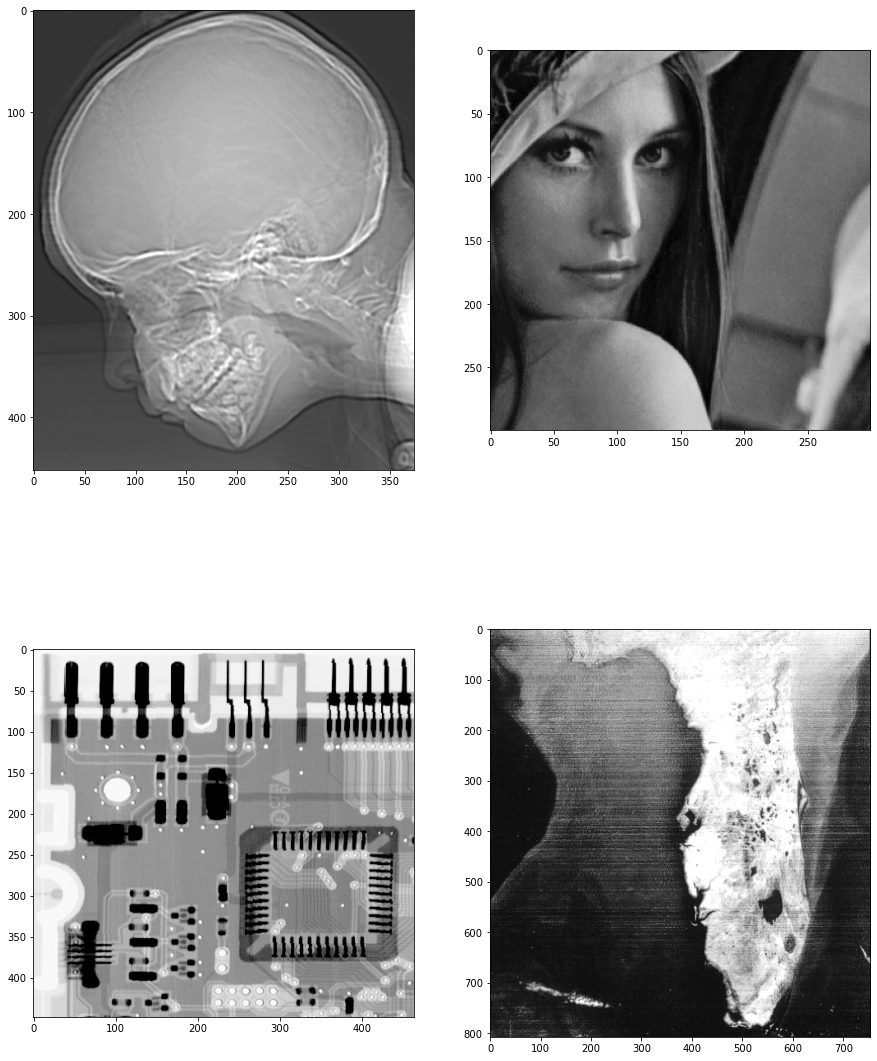

In [41]:
fig, axs = plt.subplots(2, 2 , figsize=(15 * len(denoise_types), 5 * len(img_cases)), sharex=False, sharey=False)
img_case = os.path.join(img_dir, img_cases[0])
img = cv2.imread(img_case, cv2.IMREAD_GRAYSCALE)
axs[0,0].imshow(img, cmap='gray', vmin=0, vmax=255)

img_case = os.path.join(img_dir, img_cases[1])
img = cv2.imread(img_case, cv2.IMREAD_GRAYSCALE)
axs[0,1].imshow(img, cmap='gray', vmin=0, vmax=255)

img_case = os.path.join(img_dir, img_cases[2])
img = cv2.imread(img_case, cv2.IMREAD_GRAYSCALE)
axs[1,0].imshow(img, cmap='gray', vmin=0, vmax=255)

img_case = os.path.join(img_dir, img_cases[3])
img = cv2.imread(img_case, cv2.IMREAD_GRAYSCALE)
axs[1,1].imshow(img, cmap='gray', vmin=0, vmax=255)

In [ ]:
import imp
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import noise
from PIL import Image, ImageFilter
imp.reload(noise)

# denoise_types = [noise.DENOISE_TYPE_MEDIAN]
# denoise_types = [noise.DENOISE_TYPE_CV_NLM]
denoise_types = [noise.DENOISE_TYPE_SELF_NLM]
fig, axs = plt.subplots(len(img_cases), 3 , figsize=(15 * len(denoise_types), 5 * len(img_cases)), sharex=False, sharey=False)
for i,img_case in  enumerate(img_cases) :
    img_case = os.path.join(img_dir, img_case)
    img = cv2.imread(img_case, cv2.IMREAD_GRAYSCALE)
    img_noise = noise.noisify_speckle(img)
    set_subplot_settings(img, axs[i,0], f'Original {img_case}')
    set_subplot_settings(img_noise, axs[i,1], 'Speckle Noise')

    for j,filter in enumerate(denoise_types):
        
        start = time.time()
        if filter == noise.DENOISE_TYPE_CV_NLM:
            img_denoise = cv2.fastNlMeansDenoising(img_noise, None, 10, 7, 21)
        if filter == noise.DENOISE_TYPE_SELF_NLM:
            params = (20, 6)
            img_denoise = noise.denosify(filter, img_noise, params)
        if filter == noise.DENOISE_TYPE_MEDIAN:
            params = (5)
            img_denoise = noise.denosify(filter, img_noise, params)
        # Sharpening image after denoising
        img_sharpened = Image.fromarray(img_denoise.astype('uint8'))
        img_sharpened = img_sharpened.filter(ImageFilter.UnsharpMask(radius = 1, percent = 100))
        end = time.time()
        print(str(signal_to_noise(img)) + " & " + str(signal_to_noise(img_noise)) + " & " + str(signal_to_noise(img_denoise)) + " & " + str(signal_to_noise(img_sharpened)) + " & " + str(round(end - start, 5)))
        set_subplot_settings(img_denoise, axs[i,j+2], filter + " filter")
plt.show()    

2.57331 & 1.66278 & 3.4074 & 2.94643 & 868.68423


In [10]:
def signal_to_noise(a, axis=None, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    x = np.where(sd == 0, 0, m/sd)
    return round(float(str(x)), 5)